In [3]:
import json
import numpy as np
import hist
from hist import Hist
import matplotlib.pyplot as plt

In [4]:
def load_hepdata_json(filename):
    """Load HEP-data JSON file and extract histogram information"""
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

group_map = {
    0: 'Data',
    1: 'MC',
    2: '$tt \\gamma$',
    3: '$Z\\gamma$',
    4: '$t\\gamma$',
    5: 'Other+$\\gamma$',
    6: 'nonprompt $\\gamma$'
}

In [5]:
def create_histograms(file):
    bin_list = []
    histograms = {}
    values = {}
    errors = {"stat": [], "syst": []}
    for group in group_map.values():
        values[group] = []
    
    for i, dic in enumerate(file["values"]):
        if i == 0:
            bin_list.append(dic['x'][0]["low"])
        bin_list.append(dic["x"][0]["high"])
        
        for j,y in enumerate(dic["y"]):
            values[group_map[y["group"]]].append(float(y["value"]))
            if "stat" in y["errors"][0].values():
                errors["stat"].append(float(y["errors"][0]["symerror"]))
            if "syst" in y["errors"][0].values():
                errors["syst"].append(float(y["errors"][0]["symerror"]))
    for group in group_map.values():
        histograms[group] = Hist(hist.axis.Variable(list(map(float, bin_list)), name="pt"))
        histograms[group][:] = values[group]

    return {
        "bins": bin_list,
        "histograms": histograms,
        "values": values,
        "errors": errors
    }

In [104]:
cms_color = {
    "blue": "#3f90da",
    "orange": "#ffa90e",
    "red": "#bd1f01",
    "gray": "#94a4a2",
    "purple": "#832db6",
    "brown": "#a96b59",
    "dark_prange": "#e76300",
    "beige": "#b9ac70",
    "dark_gray": "#717581",
    "light_blue": "#92dadd"
}

class MakePlot:
    def __init__(self, hist_info):
        self.hist_info = hist_info,
        self.histograms = hist_info["histograms"]
        self.bins = self.histograms["Data"].axes[0].edges
        self.centers = self.histograms["Data"].axes[0].centers
        self.bin_widths = np.diff(self.bins)
        self.errors = hist_info["errors"]
        self.data_values = np.array(self.histograms["Data"].values())
        self.mc_values = np.array(self.histograms["MC"].values())
        self.mc_components = {}
        for sample in self.histograms.keys():
            if sample not in ["Data", "MC"]:
                self.mc_components[sample] = np.array(self.histograms[sample].values())
                
        self.colors = [cms_color["orange"], cms_color["purple"], cms_color["red"], cms_color["beige"], cms_color["blue"], cms_color["dark_gray"],]
                
    def define_figure(self):
        self.fig, (self.ax, self.rax) = plt.subplots(
            2, 1, figsize=(10, 8), 
            gridspec_kw={"height_ratios": [3, 1], "hspace": 0.0}, 
            sharex=True
        )
    
    def plot_datamc(self):
        bottom = np.zeros(len(self.centers))
        for i, (name, values) in enumerate(self.mc_components.items()):
            self.ax.bar(
                self.centers, values, width=self.bin_widths,
                bottom=bottom, alpha=0.8, label=name, color=self.colors[i],
                edgecolor='black', linewidth=0.5
            )
            bottom += values
            
        self.ax.errorbar(
            self.centers, self.data_values, yerr=self.errors["stat"],
            fmt='o', color='black', markersize=6, capsize=4,
            linewidth=2, label='Data'
        )
        
        self.ax.fill_between(
            self.centers,
            self.mc_values - self.errors["syst"],
            self.mc_values + self.errors["syst"],
            step='mid', facecolor="None", alpha=0.9, hatch='////',
            label='Syst. Unc.', edgecolor='black', linewidth=0
        )
        
        self.ax.text(0.75, 0.45, '$e/\mu$', transform=self.ax.transAxes, 
               fontsize=20, fontweight='bold', va='top')
        
        self.ax.set_ylabel('Events', fontsize=15)
        self.ax.legend(fontsize=10)
        self.ax.grid(True, alpha=0.3)
        self.ax.set_title('Data/MC Comparison', fontsize=16)
        
    def plot_ratio(self):
        ratio = self.data_values / self.mc_values
        ratio_err = self.errors["stat"] / self.mc_values

        # Plot ratio
        self.rax.errorbar(self.centers, ratio, yerr=ratio_err, 
                          fmt='o', color='black', markersize=5, linewidth=1.5,
                          capsize=3, capthick=1.5, label='Data/MC')

        self.rax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5)

        syst_unc_ratio = self.errors["syst"] / self.mc_values
        self.rax.fill_between(self.centers, 1 - syst_unc_ratio, 1 + syst_unc_ratio,
                 step='mid', facecolor="None", alpha=0.9, hatch='////',
                 label='Syst. Unc.', edgecolor='black', linewidth=0)

        # Set labels and limits
        self.rax.set_xlabel('p$_T$ [GeV]')
        self.rax.set_ylabel('Data/MC')
        self.rax.set_ylim(0.5, 1.5)
        self.rax.set_xlim(self.bins[0], self.bins[-1])
        self.rax.grid(True, alpha=0.3)
        self.rax.set_xlim(self.ax.get_xlim())

        # Add bin edges as x-ticks
        # ax_bottom.set_xticks(bins)

            
    def plot_histogram(self):
        self.define_figure()
        self.plot_datamc()
        self.plot_ratio()
        plt.show()
    


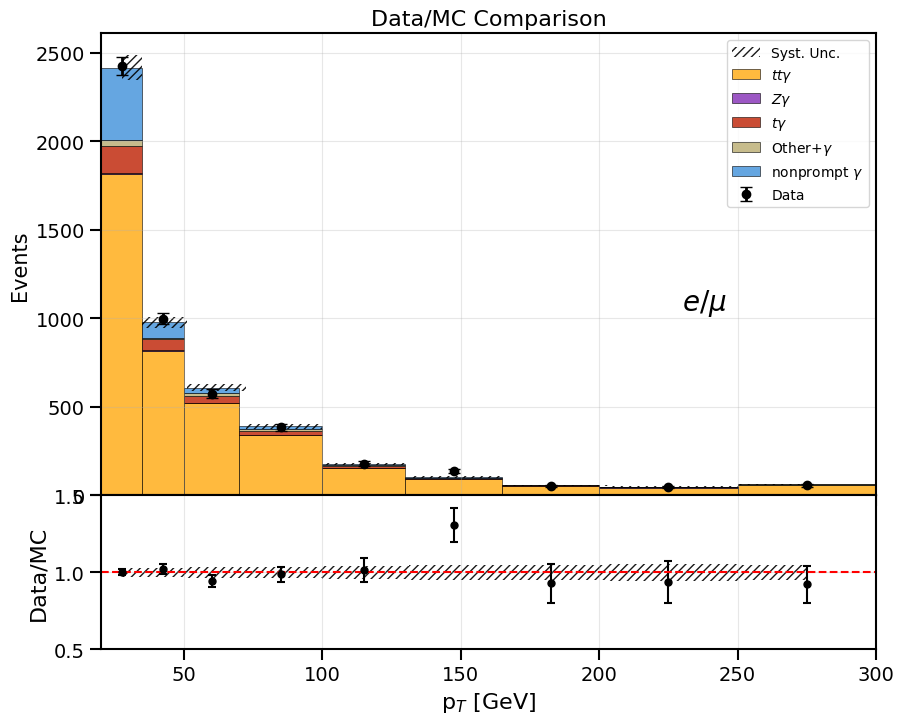

[ 27.5  42.5  60.   85.  115.  147.5 182.5 225.  275. ]


array([ 20.,  35.,  50.,  70., 100., 130., 165., 200., 250., 300.])

In [109]:
file = load_hepdata_json("Figure6a.json")
histograms_info = create_histograms(file)
make_plot = MakePlot(histograms_info)
make_plot.plot_histogram()
print(make_plot.centers)
make_plot.bins